# Baseline Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Simple Two-Step
This model is a simple growth model with selection based on fitness determined by coefficient $W$.

In [2]:
#define the simple two-step model: here, relative fitness does not change
def two_step_model(n_init, w, generations=100):
    """
    Simulate a two-step model with constant relative fitness.
    
    Parameters:
    n_init (int): Initial population size.
    w (float): Relative fitness of the mutant.
    
    Returns:
    np.ndarray: Array of population sizes at each generation.
    """
    
    # Initialize the population size
    n = n_init
    population_sizes = np.zeros(generations)
    
    for t in range(generations):
        population_sizes[t] = n
        n = n * w  # Update population size based on relative fitness
    
    return population_sizes

#same as above, but selection changes relative fitness by amount s
def two_step_with_evolving(n_init, w, s, generations=100):
    """
    Simulate a two-step model with evolving relative fitness.
    
    Parameters:
    n_init (int): Initial population size.
    w (float): Initial relative fitness of the mutant.
    s (float): Selection coefficient.
    generations (int): Number of generations to simulate.
    
    Returns:
    np.ndarray: Array of population sizes at each generation.
    """
    
    # Initialize the population size
    n = n_init
    population_sizes = np.zeros(generations)
    
    for t in range(generations):
        population_sizes[t] = n
        w = w + s  # Update relative fitness based on selection coefficient
        n = int(n * w)  # Update population size based on relative fitness

        #if we reach above the initial population size, stop
        if n > n_init:
            break
    
    # Fill the remaining generations with the last population size
    population_sizes[t+1:] = n

    return population_sizes

In [3]:
pops_noevolution = two_step_model(100, 0.5, generations=100)
pops_evolution = two_step_with_evolving(100, 0.5, 0.01, generations=100)

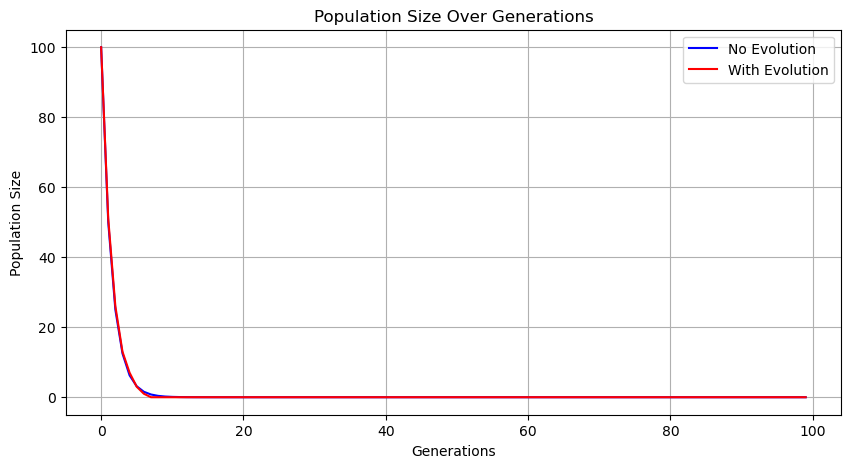

In [4]:
#plot this first run
plt.figure(figsize=(10, 5))
plt.plot(pops_noevolution, label='No Evolution', color='blue')
plt.plot(pops_evolution, label='With Evolution', color='red')
plt.title('Population Size Over Generations')
plt.xlabel('Generations')
plt.ylabel('Population Size')
plt.legend()
plt.grid()
plt.show()

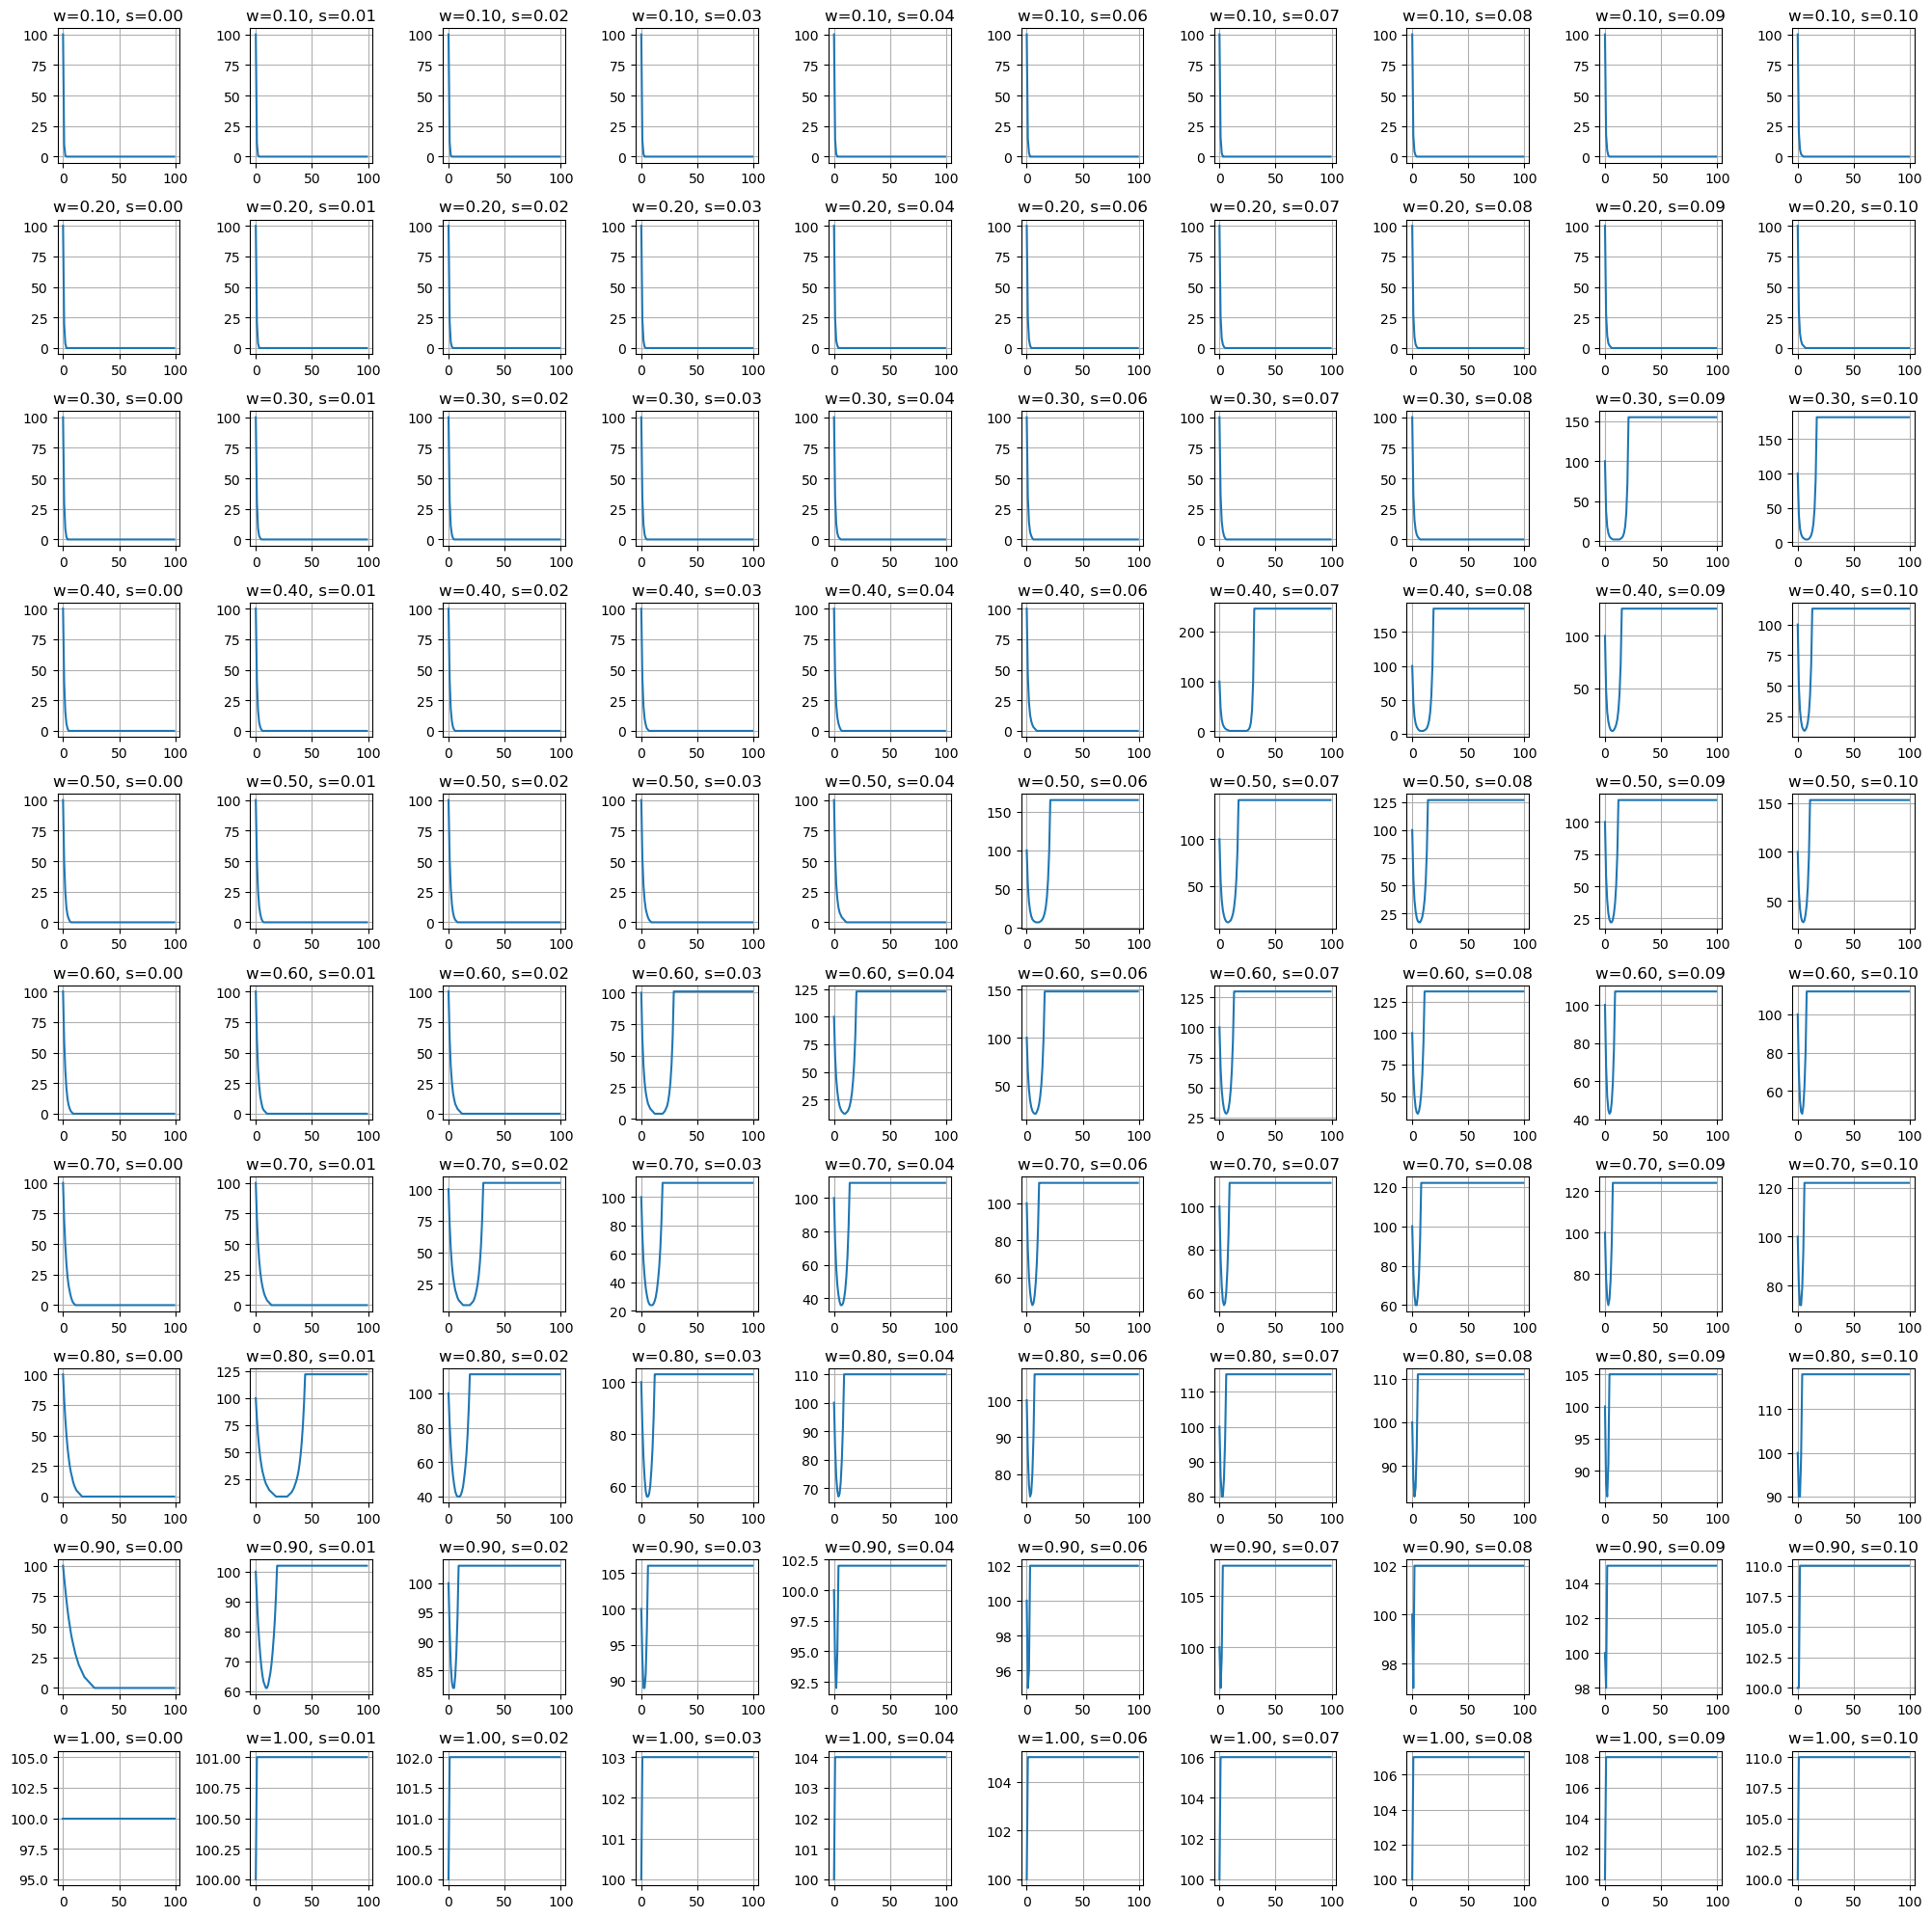

In [5]:
#try a variety of parameters
w_vals = np.linspace(0.1, 1, 10)
s_vals = np.linspace(0, 0.1, 10) #having 0 is essentially with no evolution
pops_all = []
for w in w_vals:
    for s in s_vals:
        pops = two_step_with_evolving(100, w, s, generations=100)
        pops_all.append(pops)

#plot all the runs in a grid of 10x10 subplots
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i, pops in enumerate(pops_all):
    ax = axs[i // 10, i % 10]
    ax.plot(pops)
    ax.set_title(f'w={w_vals[i // 10]:.2f}, s={s_vals[i % 10]:.2f}')
    ax.grid()
plt.tight_layout()
plt.show()

## Discrete-Time, Quantitative Genetic Model
In this model, essentially we have a bunch of loci that contribute to fitness; like most complex traits, this follows a normal distribution. 

In [26]:
#functions for model 2: discrete-time, quantitative genetic

#helper function: calculate absolute fitness
def absolute_fitness(w_max, z, w):
    return w_max * np.exp(-(z ** 2) / (2 * w))

#helper function: sample phenotypes from a normal distribution
#this has mean d_t and variance P
def sample_phenotypes(d_t, P, n):
    return np.random.normal(d_t, np.sqrt(P), n)

#helper function: calculate the absolute mean fitness
#this is the absolute fitness (above function) times the probability density of each phenotype
def absolute_mean_fitness(phenotypes, w_max, w, P):
    if len(phenotypes) == 0:
        return 0
    fitnesses = absolute_fitness(w_max, phenotypes, w)

    #get probability density of each phenotype
    probs = (1 / np.sqrt(2 * np.pi * P)) * np.exp(-(phenotypes ** 2) / (2 * P))

    #multiply fitness by probability density
    weighted_fitness = fitnesses * probs
    return np.sum(weighted_fitness) / len(phenotypes)

#helper function: change d_t
def change_dt(d_t, P, h2, w):
    return d_t + (-1 * h2 * d_t * P)/(P + w)

#now we can run the model
def quantgen_model(n_init, w_max, w, P, h2, generations=100, n_sims=1, printout=False):
    """
    Simulate a quantitative genetic model.
    
    Parameters:
    n_init (int): Population size.
    generations (int): Number of generations to simulate.
    w_max (float): Maximum absolute fitness.
    w (float): Width of corresponding Gaussian function.
    P (float): Phenotypic variance.
    h2 (float): Heritability.
    n_sims (int): Number of simulations to run.
    
    Returns:
    np.ndarray: Array of population sizes at each generation.
    """

    # Initialize first dt
    d_t = np.random.normal(0, 1)
    
    sim_results = np.zeros((n_sims, generations))
    mean_pops = np.zeros(generations)

    for sim in range(n_sims):
        n = n_init
        for t in range(generations):
            #sample phenotypes
            phenos = sample_phenotypes(d_t, P, n)

            #get the current absolute mean fitness
            mean_fitness = absolute_mean_fitness(phenos, w_max, w, P)
            n = int(n * mean_fitness)
            sim_results[sim, t] = n
            mean_pops[t] += n

            #update d_t
            d_t = change_dt(d_t, P, h2, w)

        if printout:
            print(f"Simulation {sim + 1} completed")

    mean_pops /= n_sims
    return sim_results, mean_pops

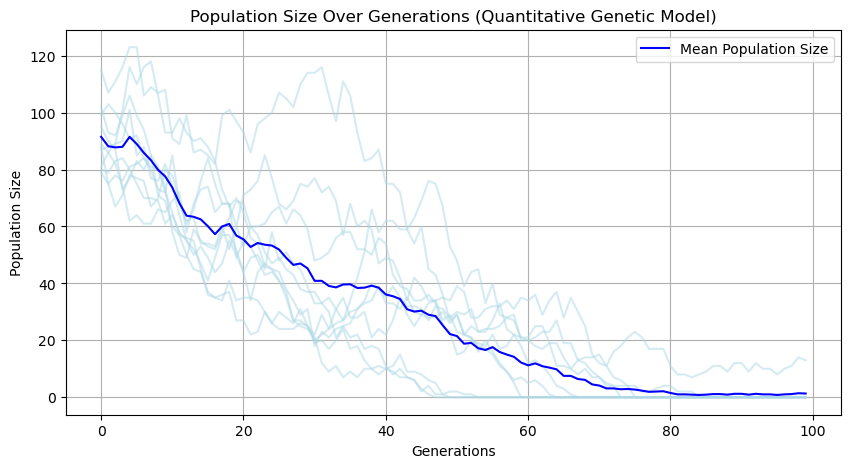

In [60]:
#run the model
n_init = 100
w_max = 3
w = 0.1
P = 0.3 
h2 = 0.6
pops, mean_pops = quantgen_model(n_init, w_max, w, P, h2, generations=100, n_sims=10)

#plot the results
plt.figure(figsize=(10, 5))
plt.plot(pops.T, color='lightblue', alpha=0.5)
plt.plot(mean_pops, color='blue', label='Mean Population Size')
plt.title('Population Size Over Generations (Quantitative Genetic Model)')
plt.xlabel('Generations')
plt.ylabel('Population Size')
plt.legend()
plt.grid()
plt.show()

Note: For the above, it is important to try SMALL changes to the parameters; otherwise population will explode in size and this simulation will take decades to run and/or brick your computer. 

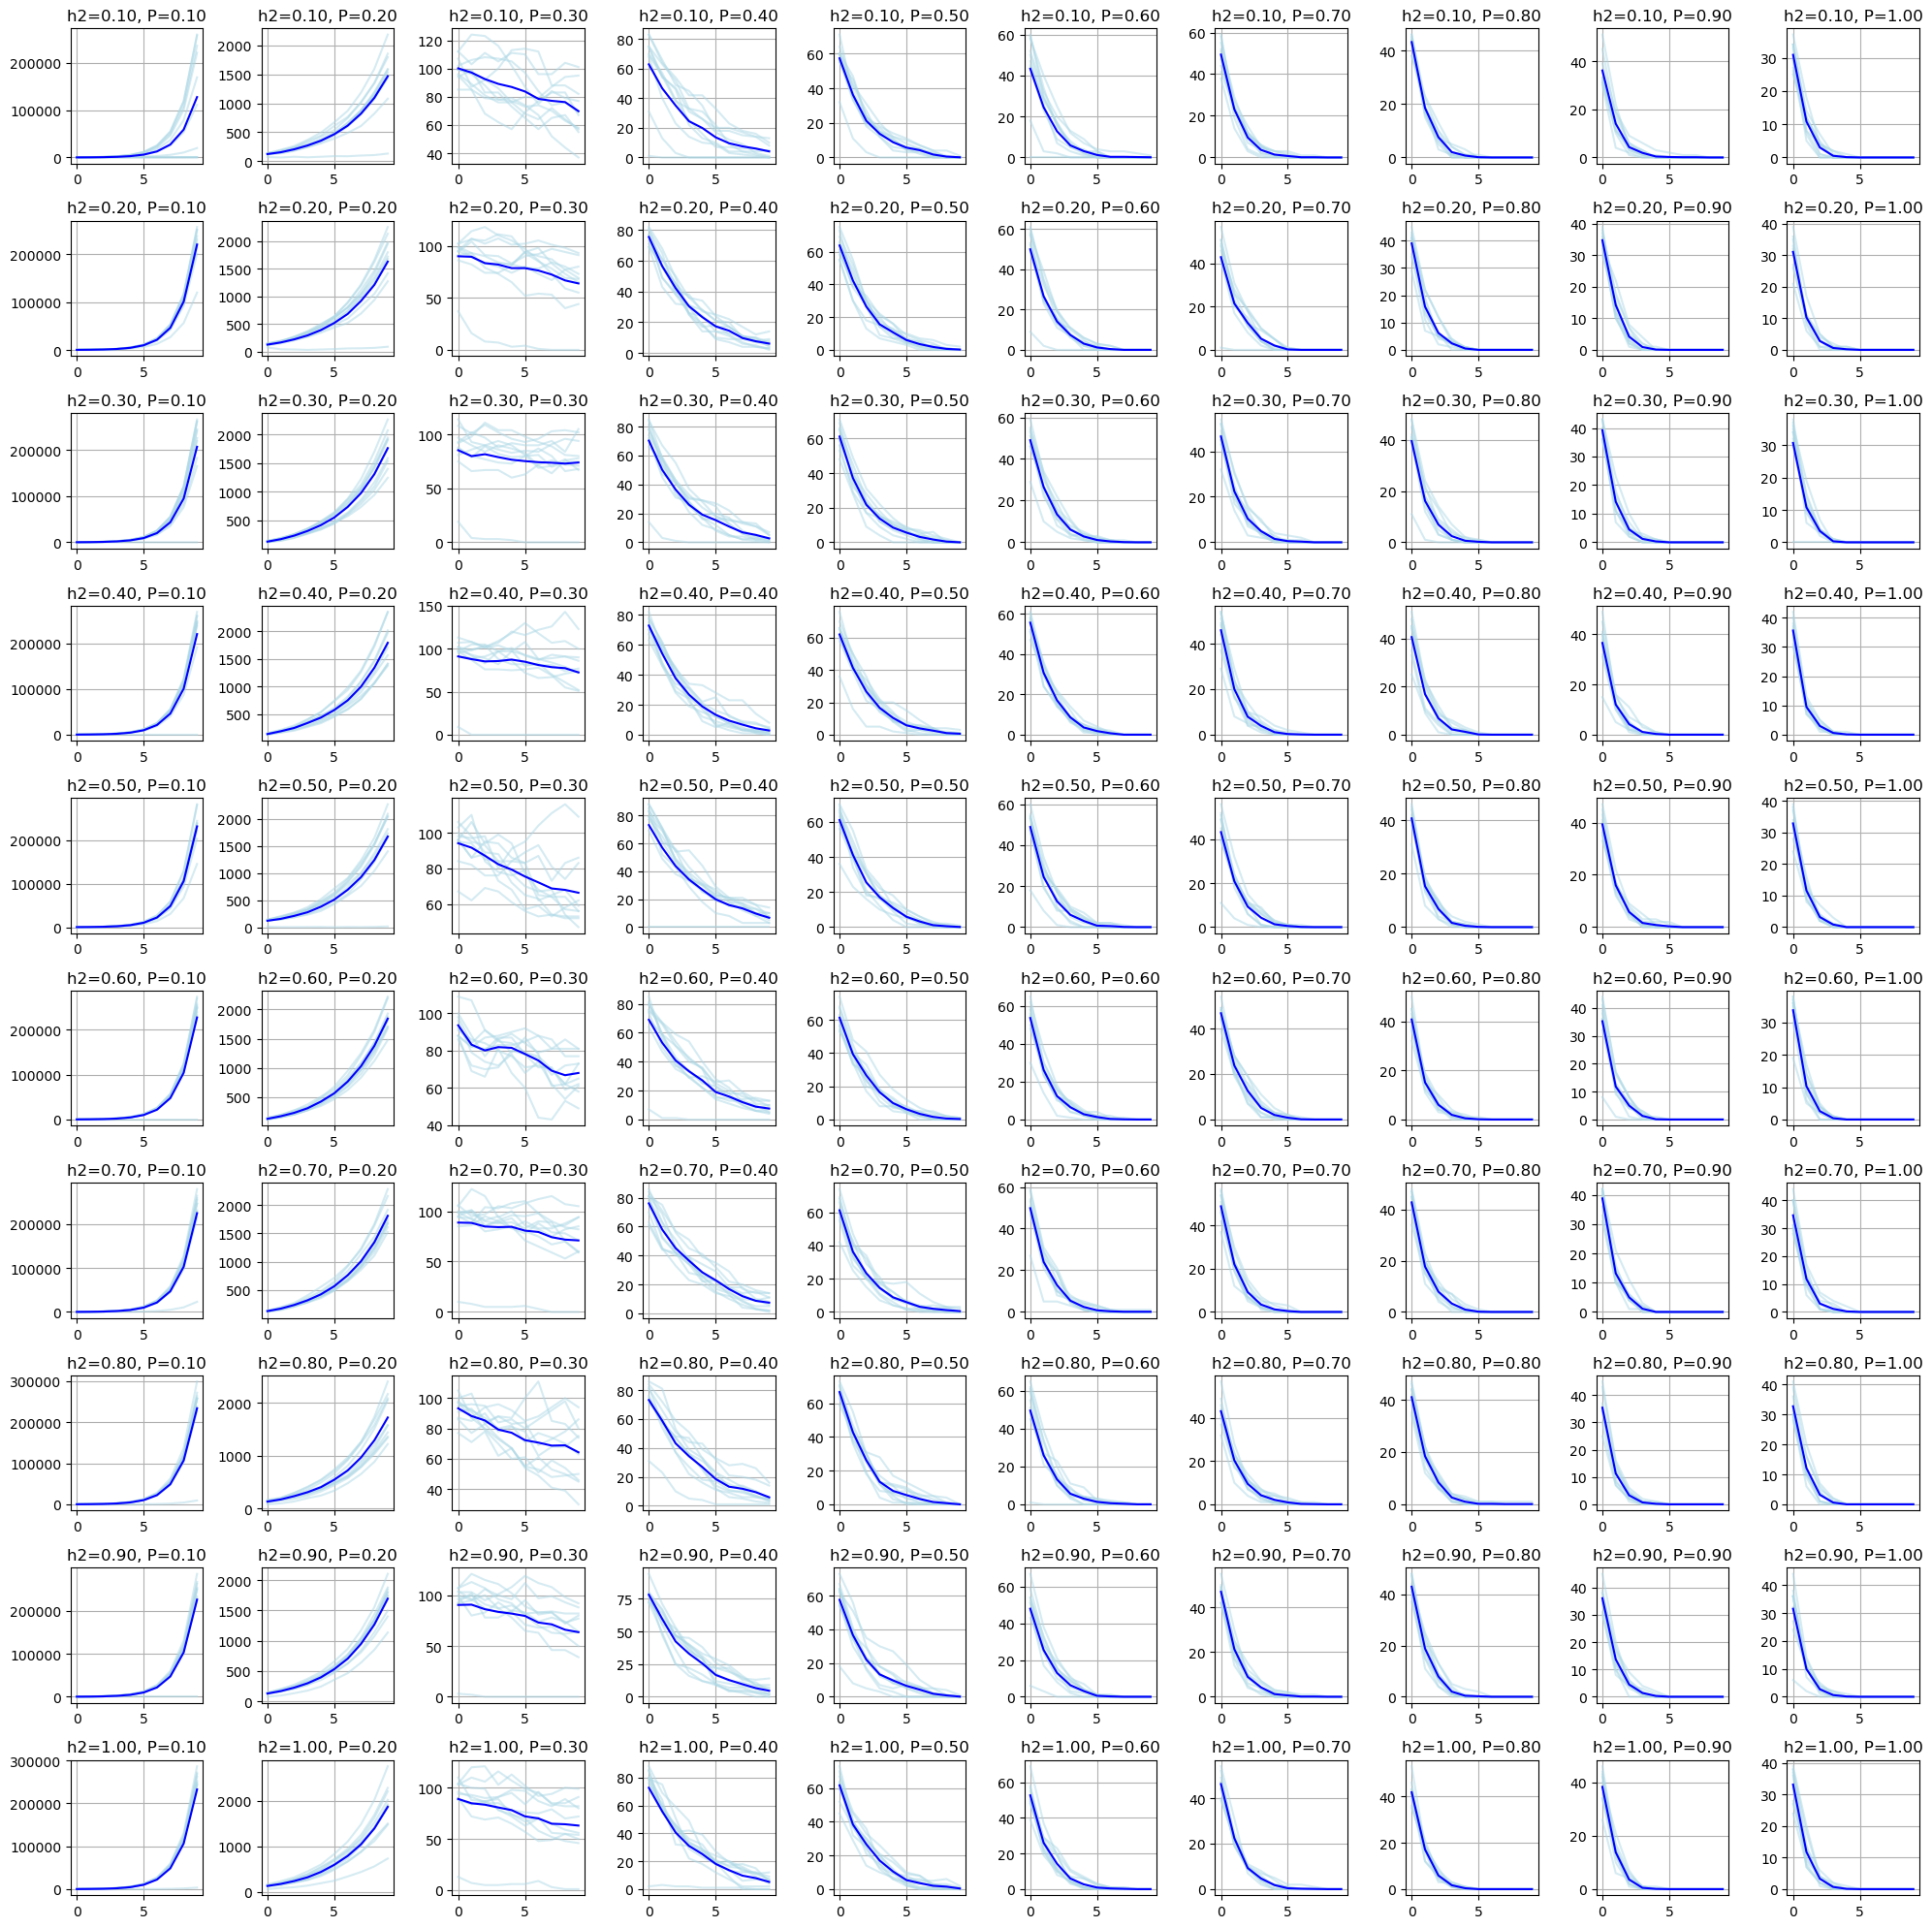

In [59]:
#same as simple two-step model, but with various values of P and h2
h2s = np.linspace(0.1, 1, 10)
Ps = np.linspace(0.1, 1, 10)
pops_all = []
mean_pops_all = []
for h2 in h2s:
    for P in Ps:
        pops, mean_pops = quantgen_model(n_init, w_max, w, P, h2, generations=10, n_sims=10)
        pops_all.append(pops)
        mean_pops_all.append(mean_pops)

#plot all the runs in a grid of 10x10 subplots
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i, pops in enumerate(pops_all):
    ax = axs[i // 10, i % 10]
    ax.plot(pops.T, color='lightblue', alpha=0.5)
    ax.plot(mean_pops_all[i], color='blue', label='Mean Population Size')
    ax.set_title(f'h2={h2s[i // 10]:.2f}, P={Ps[i % 10]:.2f}')
    ax.grid()
plt.tight_layout()
plt.show()

For the above, the authors of the paper we're following utilize $\beta_0$, initial maladaption, which is $d_0^2 / (w + P)$ and $v_0$, a proxy for initial density, that is equal to $N_c / N_0$. Please make a copy of this notebook and modify these values, so that the resulting simulations can show results. Thx.

## Continuous-time, Diploid Single Locus Model

In [92]:
#this one diploid locus model will take m_max, s, n_0, q_0 (initial maladaptation), generations as parameters
def diploid_locus_model(m_max, s, n_0, q_0, generations=100):
    """
    Simulate a diploid locus model.
    
    Parameters:
    m_max (float): Maximum relative fitness.
    s (float): Difference in fitness for the maladaptive allele.
    n_0 (int): Initial population size.
    q_0 (float): Initial maladaptation / frequency of the maladaptive allele.
    generations (int): Number of generations to simulate.
    
    Returns:
    np.ndarray: Array of population sizes at each generation.
    """

    #check: is s > m_max? if not, return an error
    if s < m_max:
        raise ValueError("Selection coefficient s must be greater than or equal to maximum mutation rate m_max.")
    
    # Initialize the population size
    n = n_0
    q = q_0
    p = 1 - q  # Frequency of the beneficial allele

    #initialize relative fitnesses
    m11 = m_max
    m12 = m_max - (s/2)
    m22 = m_max - s

    # Initialize the population size array
    population_sizes = np.zeros(generations)
    
    for t in range(generations):
        population_sizes[t] = n
        m_t = m11 * (p ** 2) + m12 * (2 * p * q) + m22 * (q ** 2)
        n_next = n * m_t + n

        #if n_next = 0, fill the rest of the generations with 0 and stop
        if n_next <= 0:
            population_sizes[t:] = 0
            break

        p_next = (m11 * (p ** 2) + m12 * (p * q)) * n / (n_next)
        q_next = 1 - p_next

        # Update population size and allele frequencies
        n = n_next
        p = p_next
        q = q_next
    
    return population_sizes

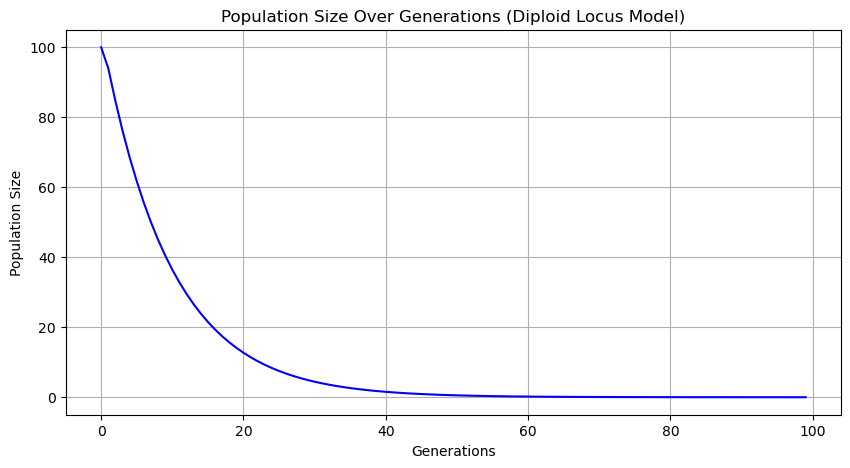

In [96]:
m_max = 0.1
s = 0.2
n_0 = 100
q_0 = 0.8
pops = diploid_locus_model(m_max, s, n_0, q_0, generations=100)

#plot the results
plt.figure(figsize=(10, 5))
plt.plot(pops, color='blue')
plt.title('Population Size Over Generations (Diploid Locus Model)')
plt.xlabel('Generations')
plt.ylabel('Population Size')
plt.grid()
plt.show()

The paper we're basing this from doesn't add much but they do look at the time spent at the critical density/critical amount as a function of the initial $q_0$ and as a function of the initial density $v_0$ so those would be things to look at in the adaptations.